# Data Prepocessing

The following steps are taken to preprocess the data.

- **1. Shapefiles**
    - Load shapefiles (stream gages, precipitation stations, boundaries).
    - Clean, simplify, and reproject shapefiles.
    - Clip and mask data based on region of interest.
    - Create Thiessen Polygons for precipitation stations for taking into account the spatial distibution of rain.
    - Extract relevant features (e.g., drainage area, station location).

- **2. Raster Data**
    - Load raster data (elevation, land cover).
    - Resample and align raster data layers.
    - Clip and mask data based on region of interest.
    - Extract key features (e.g., elevation, impervious surface).
    - Delineate watershed boundaries and extract watershed geomorphological characteristics
    - Normalize raster values.

- **3. Tabular Data**
    - Load time-series data (streamflow, precipitation).
    - Handle missing values and fill gaps.
    - Standardize time formats and indices.
    - Identify and remove outliers.
    - Resample and aggregate data to a uniform time step.
    - Create new features (e.g., moving averages).

- **4. Data Integration**
    - Spatially join shapefiles with raster and tabular data.
    - Merge time-series data based on time and location.
    - Aggregate raster features for each station or gage.

- **5. Selection of Storm Events**

- **6. Clark's parameter optmization**
    - Optmize Clark's parameters for the selected events
    - Spatially join the optmized parameters with shapefile data.

- **5. Machine Learning Preparation**
    - Scale and normalize features.
    - Split dataset into training and testing sets.
    - Encode categorical features.
    - Select most relevant features for training.


In [4]:
# Import modules
from pathlib import Path
import time
import sys
import geopandas as gpd
from plotnine import *
import warnings
from IPython.display import display, HTML, Markdown
from dotenv import load_dotenv
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re


In [5]:
# File paths
project_base_path = Path.cwd().parent.parent

In [6]:
# Add 'src' to system path
sys.path.append(str(project_base_path / 'src'))

# Ignore warnings
warnings.filterwarnings('ignore')

In [7]:
# Load tokens

load_dotenv(project_base_path / '.env')

NOAA_API_TOKEN = os.getenv('NOAA_API_TOKEN')


## 1. Shapefiles

### 1.1 Load shapefiles

In [8]:
# File paths
shapefiles_base_path = project_base_path / 'data'/ 'geo'/ 'shp'

dam_location_path = shapefiles_base_path / 'dams_location' / 'Dams.shp'

precip_stations_path = shapefiles_base_path / 'precipitation_stations' / 'precip_15.kmz'
streamgage_stations_path = shapefiles_base_path / 'streamgage_stations' / 'realstx.shp'

us_county_path = shapefiles_base_path / 'us_county' / 'tl_2024_us_county.shp'
us_state_path =  shapefiles_base_path / 'us_state' / 'tl_2024_us_state.shp'

world_utm_zones_path = shapefiles_base_path.parent / 'json' / 'World_UTM_Grid.geojson'

upper_hudson_basin_path = shapefiles_base_path / 'upper_hudson_basin' / 'upper_hudson_basin.shp'
upper_hudson_basin_1km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_1km_buffer' / 'upper_hudson_basin_1km_buffer.shp'
upper_hudson_basin_5km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_5km_buffer' / 'upper_hudson_basin_5km_buffer.shp'
upper_hudson_basin_10km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_10km_buffer' / 'upper_hudson_basin_10km_buffer.shp'
upper_hudson_basin_30km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_30km_buffer' / 'upper_hudson_basin_30km_buffer.shp'

In [9]:
# Read shapefiles
try:
    start_time = time.time()

    precip_stations = gpd.read_file(precip_stations_path)
    streamgage_stations = gpd.read_file(streamgage_stations_path)

    dam_location = gpd.read_file(dam_location_path)

    us_county = gpd.read_file(us_county_path)
    us_state = gpd.read_file(us_state_path)

    world_utm_zones = gpd.read_file(world_utm_zones_path)

    upper_hudson_basin = gpd.read_file(upper_hudson_basin_path)
    upper_hudson_basin_1km_buffer = gpd.read_file(upper_hudson_basin_1km_buffer_path)
    upper_hudson_basin_5km_buffer = gpd.read_file(upper_hudson_basin_5km_buffer_path)
    upper_hudson_basin_10km_buffer = gpd.read_file(upper_hudson_basin_10km_buffer_path)
    upper_hudson_basin_30km_buffer = gpd.read_file(upper_hudson_basin_30km_buffer_path)

    end_time = time.time()

    print('Shapefiles read successfully. Time elapsed:', round(end_time - start_time, 2), 'seconds')
except Exception as err:
    print('Error reading shapefiles:', err)

Shapefiles read successfully. Time elapsed: 9.94 seconds


#### 1.2. Cleaning and Reprojection
##### 1.2.1 Cleaning
- **Precipitation Stations**

The Precipitation Station location covers the entire united states, is in kmz format and the ID station is encoded in HTML code, and has other irrelevant attributes. The following steps will be taken to clean the file:

- 1. Clip the data to have precipitation stations only in area of interest.
- 2. Decode the HTML code to extract the station ID and elevation.
- 3. Drop irrelevant attributes.
- 4. Add begin and end historical data info.

        **1. Clip the data**

        For the mask, we will use the study region + 30km buffer to make ensure that none of possible precipitation station is left outside. We will define later which station to use. 


In [26]:
# Clip the data
precip_stations_clipped = gpd.clip(precip_stations.to_crs(upper_hudson_basin_30km_buffer.crs), upper_hudson_basin_30km_buffer)

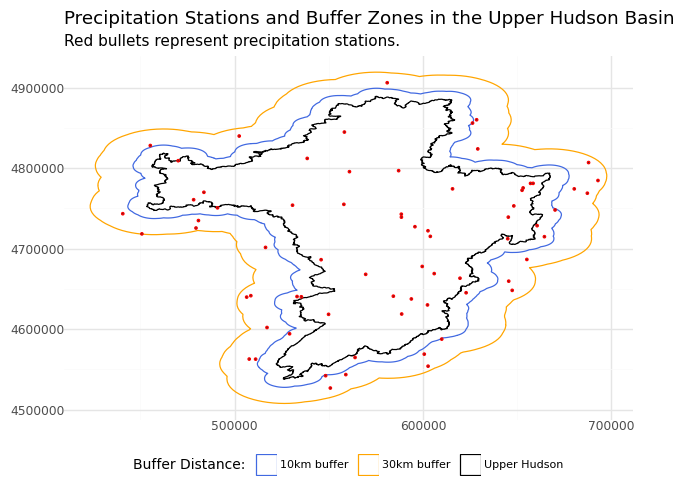

In [12]:
geom_merged = pd.concat(
    [
        upper_hudson_basin.to_crs(precip_stations_clipped.crs)[['geometry']].assign(LAYER='Upper Hudson'),
        upper_hudson_basin_10km_buffer[['geometry']].assign(LAYER='10km buffer'),
        upper_hudson_basin_30km_buffer[['geometry']].assign(LAYER='30km buffer')
    ]
)

precip_station_map = (
    ggplot(geom_merged)
    + geom_map(
        mapping=aes(geometry='geometry', color = 'LAYER'),
        fill = None
    )
    + geom_map(
        data = precip_stations_clipped[['geometry']],
        mapping=aes(gemetry='geometry'),
        color='red'
    )
    + labs(title='Precipitation Stations and Buffer Zones in the Upper Hudson Basin',
           subtitle= 'Red bullets represent precipitation stations.')

    # Manually define colors
    + scale_color_manual(
        name='Buffer Distance:',
        values={
            'Upper Hudson': 'black',
            '10km buffer': 'royalblue',
            '30km buffer': 'orange'
            }
    )
    + coord_cartesian()
    + theme_minimal()
    + theme(
        legend_title=element_text(size=10),
        legend_text=element_text(size=8),
        legend_position='bottom'
    )
)
precip_station_map.draw()




**2. Decode HTML**

The station ID and elevation attributes, which we want to keep, are encoded in HTML tags. We will extract those attributes and add it to a new column called `precip_station_id`  and `precip_station_elev` respectively. Precipitation elevation is in meters. Below is an example of precipitation station description encoded as html:`

In [13]:
print(precip_stations_clipped['description'].iloc[0])


    
    <table>
    <tr><td>ID: COOP:280907</td></tr>
    <tr><td>COUNTRY: United States</td></tr>
    <tr><td>LATITUDE: 40.89174</td></tr>
    <tr><td>LONGITUDE: -74.39635</td></tr>
    <tr><td>ELEVATION: 85.3 m.</td></tr>
    <tr><td></td></tr>
    </table>
    <table>
    <tr><td><form action="https://www.ncdc.noaa.gov/cdo-web/mapReview" method="post">
        <input type="hidden" name="_dataSet" value="PRECIP_15"/>
        <input type="hidden" name="_stationId" value="COOP:280907"/>
        <input type="submit" value="Access Station Data"/>
    </form></td></tr>
    </table> 
  


In [28]:
# Define function to extract precipitation station id and elevation attributes
def decode_precipt_station_html(html):
    soup = BeautifulSoup(html, 'html.parser')
    id = soup.find('td').text.split(': ')[1].strip()
    elevation = soup.find_all('td')[4].text.split(': ')[1]
    elevation_int = int(re.findall(r'\d+', elevation)[0])

    return pd.Series([id, elevation_int])

# Extract attributes
try:
    precip_stations_clipped[['precip_station_id', 'precip_station_elev']] = precip_stations_clipped['description'].apply(decode_precipt_station_html)
    print('Attribute successfully extracted.')
except Exception as err:
    print(f'Failed to extract attibutes: {err}')

Attribute successfully extracted.


**3. Drop irrelevant attributes**

Below is shows all of the attributes in our precipitation station layer. The relevant attributes are: `Name`, `begin` (empty, but we will get this data later), `end` (empty, but we will get this data later), `geometry`, `precip_station_id` and `precip_station_elev`.

In [29]:
precip_stations_clipped.head()

,id,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry,precip_station_id,precip_station_elev
30,31,"BOONTON 1 SE, NJ US",\n \n <table>\n <tr><td>ID: COOP:2809...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (550850.97 4526914.624 0),COOP:280907,85
1,2,"CHARLOTTEBURG RESERVOIR, NJ US",\n \n <table>\n <tr><td>ID: COOP:2815...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (548355.898 4542242.25 0),COOP:281582,237
2,3,"WANAQUE RAYMOND DAM, NJ US",\n \n <table>\n <tr><td>ID: COOP:2891...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (559071.261 4543608.511 0),COOP:289187,71
225,226,"PLEASANTVILLE, NY US",\n \n <table>\n <tr><td>ID: COOP:3066...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (602750.905 4554064.92 0),COOP:306674,97
438,439,"DINGMANS FERRY, PA US",\n \n <table>\n <tr><td>ID: COOP:3621...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (511176.454 4562818.525 0),COOP:362160,131


In [30]:
# Remove irrelevant attributes
keep_attributes = ['Name', 'begin','end', 'geometry', 'precip_station_id', 'precip_station_elev']
precip_stations_clipped = precip_stations_clipped[keep_attributes]
precip_stations_clipped.head()

,Name,begin,end,geometry,precip_station_id,precip_station_elev
30,"BOONTON 1 SE, NJ US",NaT,NaT,POINT Z (550850.97 4526914.624 0),COOP:280907,85
1,"CHARLOTTEBURG RESERVOIR, NJ US",NaT,NaT,POINT Z (548355.898 4542242.25 0),COOP:281582,237
2,"WANAQUE RAYMOND DAM, NJ US",NaT,NaT,POINT Z (559071.261 4543608.511 0),COOP:289187,71
225,"PLEASANTVILLE, NY US",NaT,NaT,POINT Z (602750.905 4554064.92 0),COOP:306674,97
438,"DINGMANS FERRY, PA US",NaT,NaT,POINT Z (511176.454 4562818.525 0),COOP:362160,131


**4. Add begin and end dates**

The downloaded precipitation stations location layer does not have `begin` and `end`info on its attributes. This info is import to dowloading ([see this notebook](../data%20download/data_download.ipynb)) the historical precipitation data. We retrieve this info from NOOA API. [Documentation available here](https://www.ncdc.noaa.gov/cdo-web/webservices/v2).

In [53]:
def get_precip_station_operational_dates(station_id):
    # Setting for Rest API request
    base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/'
    headers = {"Token":NOAA_API_TOKEN}
    endpoint = 'datasets'
    parameters = {'stationid':station_id}

    response = requests.get(url=base_url + endpoint, headers=headers, params=parameters)
    data = response.json()

    begin = data.get('results')[0].get('mindate')
    end  = data.get('results')[0].get('maxdate')
    
    return {'begin':begin, 'end':end}



In [54]:
get_precip_station_operational_dates(precip_stations_clipped['precip_station_id'].iloc[0])


{'begin': '1970-05-12', 'end': '2014-01-01'}

In [50]:
for a, b in precip_stations_clipped.iterrows():
    print(precip_stations_clipped.loc[a]['begin'])

NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT


In [48]:
precip_stations_clipped.loc[225]['begin']

NaT

In [8]:
parameters2 = {'stationid':'COOP:267369',
               'datasetid':'PRECIP_15',
               'startdate':'2012-10-31',
               'enddate':'2012-12-31'}
response2 = requests.get(url=base_url + 'data', headers=headers, params=parameters2)
response2.json()

{'metadata': {'resultset': {'offset': 1, 'count': 11, 'limit': 25}},
 'results': [{'date': '2012-10-31T23:45:00',
   'datatype': 'QGAG',
   'station': 'COOP:267369',
   'attributes': ',,HT',
   'value': 81},
  {'date': '2012-11-01T00:00:00',
   'datatype': 'QGAG',
   'station': 'COOP:267369',
   'attributes': ',,HT',
   'value': 81},
  {'date': '2012-11-01T00:15:00',
   'datatype': 'QGAG',
   'station': 'COOP:267369',
   'attributes': 'g,,HT',
   'value': 0},
  {'date': '2012-11-01T00:15:00',
   'datatype': 'QPCP',
   'station': 'COOP:267369',
   'attributes': 'g,,HT',
   'value': 0},
  {'date': '2012-11-30T23:45:00',
   'datatype': 'QGAG',
   'station': 'COOP:267369',
   'attributes': ',,HT',
   'value': 81},
  {'date': '2012-12-01T00:00:00',
   'datatype': 'QGAG',
   'station': 'COOP:267369',
   'attributes': ',,HT',
   'value': 81},
  {'date': '2012-12-01T00:15:00',
   'datatype': 'QGAG',
   'station': 'COOP:267369',
   'attributes': 'N,,HT',
   'value': 81},
  {'date': '2012-12-01T

In [26]:
response1.json()

{}

#### 1.2.2. Reprojection

When working with geospatial data in the Upper Hudson River Basin, selecting an appropriate map projection is essential to ensure the accuracy of spatial attribute calculations, such as area and perimeter. For this study, the **NAD83 datum** has been chosen as it is widely used for regional geospatial analysis within the United States. Specifically, we will utilize the **NAD83 / UTM Zone 18N (EPSG:26918)** projection, which is well-suited for the geographic extent of the Hudson River Basin.

The UTM Zone 18N projection minimizes distortions in distance and area measurements by dividing the Earth into zones optimized for small regions. This makes it ideal for hydrological studies and sub-basin analyses, where precision is critical. The projection's use of meters as the measurement unit simplifies calculations of spatial attributes, ensuring consistency and ease of interpretation.

For larger-scale or cross-basin analyses, equal-area projections such as **Albers Equal Area (EPSG:5070)** or **Lambert Conformal Conic (EPSG:102009)** can be considered. However, for this focused study on sub-basins within the Upper Hudson River region, the selected UTM projection provides the most practical and accurate framework.

This notebook demonstrates the workflow of analyzing geospatial data with Python, starting from data preprocessing, reprojecting datasets, and extracting key attributes, all while leveraging the NAD83 datum for spatial accuracy.

In [27]:
# Filter UTM bounds to be within the bounds of the upper hudson basin
upper_hudson_basin_bounds = list(upper_hudson_basin.total_bounds)

utm_bounds = world_utm_zones.bounds

utm_intersecting_bounds = (
    (utm_bounds['minx'] < upper_hudson_basin_bounds[2]) &  # UTM left < Basin right
    (utm_bounds['maxx'] > upper_hudson_basin_bounds[0]) &  # UTM right > Basin left
    (utm_bounds['miny'] < upper_hudson_basin_bounds[3]) &  # UTM bottom < Basin top
    (utm_bounds['maxy'] > upper_hudson_basin_bounds[1])    # UTM top > Basin bottom
)
world_utm_zones_filtered = world_utm_zones[utm_intersecting_bounds]

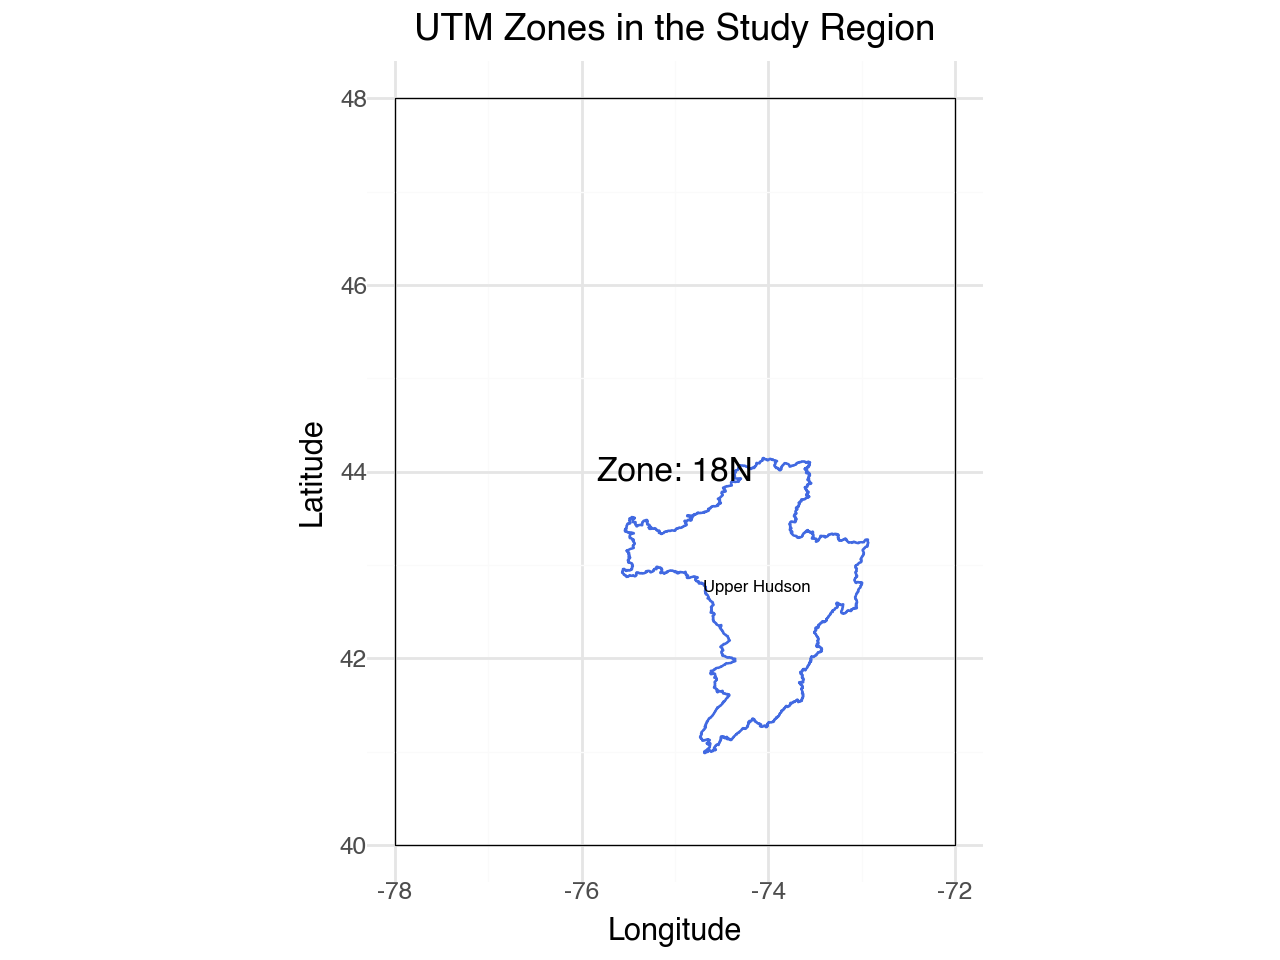

In [51]:
world_utm_zones_filtered['lon'] = world_utm_zones_filtered.centroid.x
world_utm_zones_filtered['lat'] = world_utm_zones_filtered.centroid.y

world_utm_zones_filtered['ZONE_str'] = 'Zone: ' + world_utm_zones_filtered['ZONE'].astype(str)+'N'
utm_zones_map = (
    ggplot(upper_hudson_basin)
        + geom_map(
            mapping=aes(geometry="geometry"),
            inherit_aes=True, 
            color = 'royalblue',
            fill=None
        )
         + geom_text(
            mapping=aes(x="lon", y="lat", label="name"),
            size=6,
            color="black"
        )
        + geom_map(
            mapping=aes(geometry="geometry"),
            data=world_utm_zones_filtered,
            inherit_aes=False,
            color="black",
            size=0.25,
            fill = None
        )
        + geom_text(
            mapping=aes(x="lon", y="lat", label="ZONE_str"),
            size=12,
            color="black",
            data = world_utm_zones_filtered,
            inherit_aes=False
        )
        + coord_fixed()
        + theme_minimal()
        + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
        + labs(title="UTM Zones in the Study Region", x="Longitude", y="Latitude")
    
)
utm_zones_map
                 

In [29]:
epsg = 26918 # UTM Zone 18N

In [30]:
# us_state
if us_state[~us_state.is_valid].empty:
    print('No invalid geometry for us_state')
else:
    print('The following geomtries from us_state are invalid')
    us_state[~us_state.is_valid]

# us_county
if us_county[~us_county.is_valid].empty:
    print('No invalid geometry for us_county')
else:
    print('The following geomtries from us_county are invalid')
    us_county[~us_county.is_valid]

No invalid geometry for us_state
No invalid geometry for us_county


In [31]:
us_state[~us_state.is_valid]

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
